<a href="https://colab.research.google.com/github/LeeDongGeon1996/TensorFlow-study-note/blob/master/my-practice/Experiment_06_Create_%22NEW_MNIST%22_data_using_the_model_trained_by_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment_06_Create "NEW MNIST" data using the model trained by MNIST

> ## conclustion
 * It doesn't work.... :(
 * [input] - [new model] ---[fetch created image]--- [trained model] - [output]
 * My goal was the new model makes new MNIST data image.
 * but created images didn't look like MNIST image...

## Importing Libraries

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

TensorFlow 2.x selected.
2.1.0
2.2.4-tf


## Hyper Parameters

In [0]:
learning_rate = 0.001
training_epochs = 1
batch_size = 100

tf.random.set_seed(777)

## Creating a Checkpoint Directory

In [0]:
cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'minst_cnn_func'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, model_dir_name)

## MNIST/Fashion MNIST Data

In [0]:
## MNIST Dataset #########################################################
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################

## Datasets

In [5]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()    
    
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
    
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)    
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

11493376/11490434 [==============================] - 0s 0us/step


## Model Function

In [0]:
def create_model():
    inputs = keras.Input(shape=(28, 28, 1))
    conv1 = keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(inputs)
    pool1 = keras.layers.MaxPool2D(padding='SAME')(conv1)
    conv2 = keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(pool1)
    pool2 = keras.layers.MaxPool2D(padding='SAME')(conv2)
    conv3 = keras.layers.Conv2D(filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)(pool2)
    pool3 = keras.layers.MaxPool2D(padding='SAME')(conv3)
    pool3_flat = keras.layers.Flatten()(pool3)
    dense4 = keras.layers.Dense(units=256, activation=tf.nn.relu)(pool3_flat)
    drop4 = keras.layers.Dropout(rate=0.4)(dense4)
    logits = keras.layers.Dense(units=10)(drop4)
    return keras.Model(inputs=inputs, outputs=logits)

In [7]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0     

## Loss Function

In [0]:
@tf.function
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        y_pred=logits, y_true=labels, from_logits=True))    
    return loss   

## Calculate Gradient

In [0]:
@tf.function
def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

## Caculating Model's Accuracy

In [0]:
@tf.function
def evaluate(model, images, labels):
    logits = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

## Optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

## Creating a Checkpoint

In [0]:
checkpoint = tf.train.Checkpoint(cnn=model)

## Training

In [0]:
@tf.function
def train(model, images, labels):
    grads = grad(model, images, labels)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [16]:
model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(x=train_dataset, epochs=3, validation_data=test_dataset)

Train for 600 steps, validate for 100 steps
Epoch 1/3
600/600 [==============================] - 98s 164ms/step - loss: 0.1410 - accuracy: 0.9562 - val_loss: 0.0404 - val_accuracy: 0.9861
Epoch 2/3
600/600 [==============================] - 98s 163ms/step - loss: 0.0535 - accuracy: 0.9840 - val_loss: 0.0242 - val_accuracy: 0.9920
Epoch 3/3
600/600 [==============================] - 98s 164ms/step - loss: 0.0384 - accuracy: 0.9882 - val_loss: 0.0335 - val_accuracy: 0.9891


## Save trained model

In [17]:
model_path = 'my-save/saved.h5'
!rm -r my-save
!mkdir my-save
model.save('my-save/saved.h5')

rm: cannot remove 'my-save': No such file or directory


In [18]:
!ls

checkpoints  my-save  sample_data


## Load trained model

In [19]:
new1_model = tf.keras.models.load_model(model_path)
new1_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0     

In [20]:
evaluate(new1_model,test_images, test_labels)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9891>

## Create new model to make MNIST image

In [0]:
def norm_as_activation(x):
  #이미지 인풋인 상황과 동일하게 만들어줘야함.
  norm = (x-tf.math.reduce_min(x))/(tf.math.reduce_max(x) - tf.math.reduce_min(x))
  #100은 batch size를 의미
  return tf.reshape(norm, (100,28,28,1))

def create_image_model(trained_model):
  inputs = keras.Input(shape=(10,))
  dense1 = keras.layers.Dense(units=256, activation=tf.nn.relu)(inputs)
  dense2 = keras.layers.Dense(units=512, activation=tf.nn.relu)(dense1)
  dense3 = keras.layers.Dense(units=1024, activation=tf.nn.relu)(dense2)
  drop1 = keras.layers.Dropout(rate=0.4)(dense3)
  logits = keras.layers.Dense(units=784)(drop1)

  activation = keras.layers.Activation(norm_as_activation)(logits)
  trained_output = trained_model(activation, training=False)
  return keras.Model(inputs=inputs, outputs=logits), keras.Model(inputs=inputs, outputs=trained_output)


## Prepare dataset

In [0]:
trained_model = tf.keras.models.load_model(model_path)
new_model, ensemble_model = create_image_model(trained_model)

## Train

In [23]:
new_optimizer = keras.optimizers.Adam()
new_train_labels = train_labels.copy()
print(new_train_labels)

ensemble_model.compile(optimizer=new_optimizer, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
ensemble_model.fit(new_train_labels, train_labels, batch_size=100)


[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Train on 60000 samples
60000/60000 [==============================] - 131s 2ms/sample - loss: 0.0154 - accuracy: 0.9957


## Show images created by the new model.

In [24]:
import matplotlib.pyplot as plt

def norm_as_image(x):
  #이미지 인풋인 상황과 동일하게 만들어줘야함.
  norm = ((x-tf.math.reduce_min(x))/(tf.math.reduce_max(x) - tf.math.reduce_min(x))) * 255
  print(norm.shape)
  reshape_image = tf.reshape(norm, (60000, 28,28))
  return reshape_image

output = new_model(new_train_labels, training=False)
created_images = norm_as_image(output)
print(created_images.shape)

(60000, 784)
(60000, 28, 28)


tf.Tensor(6, shape=(), dtype=int64)


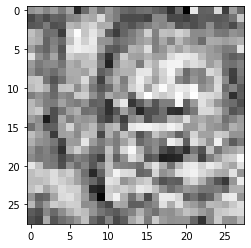

prediction : tf.Tensor([6], shape=(1,), dtype=int64)


In [25]:
num = 18
print(tf.argmax(train_labels[num]))
plt.imshow(created_images[num], cmap='Greys')
plt.show()

as_input = tf.reshape(created_images[num], (1,28,28,1))
print("prediction : " + str(tf.argmax(trained_model.predict(as_input), -1)))

## Try again with another new model.

In [0]:
def create_image_model2(trained_model):
  inputs = keras.Input(shape=(10,))
  dense1 = keras.layers.Dense(units=256, activation=tf.nn.relu)(inputs)
  dense2 = keras.layers.Dense(units=512, activation=tf.nn.relu)(dense1)
  dense3 = keras.layers.Dense(units=1024, activation=tf.nn.relu)(dense2)
  drop1 = keras.layers.Dropout(rate=0.4)(dense3)
  dense4 = keras.layers.Dense(units=1024, activation=tf.nn.relu)(drop1)
  dense5 = keras.layers.Dense(units=2048, activation=tf.nn.relu)(dense4)
  dense6 = keras.layers.Dense(units=784, activation=tf.nn.relu)(dense5)
  dense7 = keras.layers.Dense(units=784, activation=tf.nn.relu)(dense6)
  logits = keras.layers.Dense(units=784)(dense7)

  activation = keras.layers.Activation(norm_as_activation)(logits)
  trained_output = trained_model(activation, training=False)
  return keras.Model(inputs=inputs, outputs=logits), keras.Model(inputs=inputs, outputs=trained_output)



In [27]:
trained_model = tf.keras.models.load_model(model_path)
new_model2, ensemble_model2 = create_image_model2(trained_model)
new_optimizer = keras.optimizers.Adam()
new_train_labels = train_labels.copy()
print(new_train_labels)

ensemble_model2.compile(optimizer=new_optimizer, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
ensemble_model2.fit(new_train_labels, train_labels, epochs=2, batch_size=100)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Train on 60000 samples
Epoch 1/2
60000/60000 [==============================] - 168s 3ms/sample - loss: 0.0899 - accuracy: 0.9691
Epoch 2/2
60000/60000 [==============================] - 167s 3ms/sample - loss: 2.9537e-06 - accuracy: 1.0000


In [28]:
output = new_model2(new_train_labels, training=False)
created_images = norm_as_image(output)
print(created_images.shape)
#print(created_images[0])


(60000, 784)
(60000, 28, 28)


tf.Tensor(8, shape=(), dtype=int64)


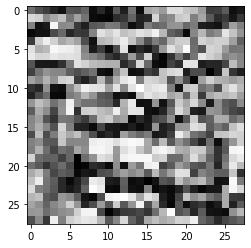

prediction : tf.Tensor([8], shape=(1,), dtype=int64)


In [32]:
num = 11239

print(tf.argmax(train_labels[num]))
plt.imshow(created_images[num], cmap='Greys')
plt.show()

as_input = tf.reshape(created_images[num], (1,28,28,1))
print("prediction : " + str(tf.argmax(trained_model.predict(as_input), -1)))